In [4]:
import torch
from models.resnetv2 import ResNet50
from torchvision import transforms
from PIL import Image
from melanoma.melanoma_loader import Melanoma_loader
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient
from zennit.image import imgify

In [18]:
from PIL import Image

WIDTH = 256
HEIGHT = 256
ROOT = "melanoma/data/train/train/"

def stacked_img(img_path, extra_img):
    img = Image.open(ROOT + img_path + ".jpg")

    new_im = Image.new('RGB', (2 * WIDTH, HEIGHT))
    new_im.paste(img, (0, 0))
    new_im.paste(extra_img, (WIDTH, 0))
    return new_im

def show_sample(img_path):
    img = Image.open(ROOT + img_path + ".jpg")
    return img

def iterate_class(dataset, find_melanoma=1):
    for idx in range(len(dataset)):
        if dataset[idx][1] == find_melanoma:
            yield dataset[idx][0].view(1, 3, 256, 256), dataset.lookup_path(idx)

path_to_model = 'model_melanoma'

model = ResNet50(out_features = 2, freeze = True, in_channels = 3)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
model.load_state_dict(checkpoint1['model'], strict=False)
model.eval()

make_dataset = lambda: Melanoma_loader(root = "melanoma/data/train/train", ann_path = "melanoma/data/test_set.csv",
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

melanoma_generator = iterate_class(make_dataset(), find_melanoma=1)
nonmelanoma_generator = iterate_class(make_dataset(), find_melanoma=0)

## Find a {false, true} x {positive, negative}

Expected target: 1, actual target: 1.


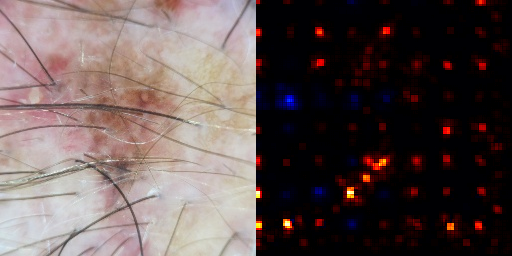

Expected target: 0, actual target: 1.


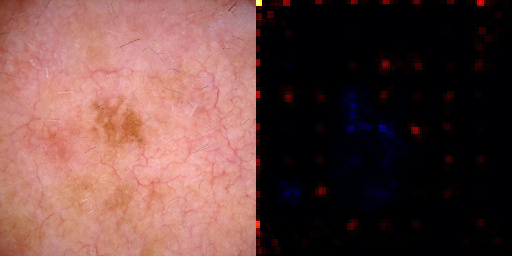

Expected target: 0, actual target: 0.


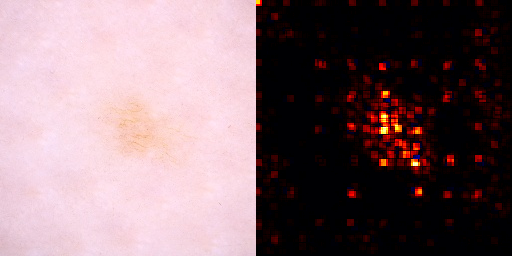

Expected target: 1, actual target: 0.


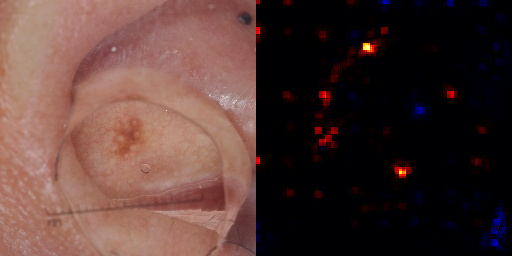

In [19]:
# Based on https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

def output_to_target(output):
    return output.argmax().item()

for actual_target, expected_target, generator in [
    (1, 1, melanoma_generator), 
    (1, 0, melanoma_generator), 
    (0, 0, nonmelanoma_generator),
    (0, 1, nonmelanoma_generator)
    ]:
    test_tensor, path = next(generator)

    # use the ResNet-specific canonizer
    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    target = torch.eye(2)[[actual_target]]

    output = None
    while output is None or output_to_target(output) != expected_target:
        # create the attributor, specifying model and composite
        test_tensor, path = next(generator)
        with Gradient(model=model, composite=composite) as attributor:
            # compute the model output and attribution
            output, attribution = attributor(test_tensor, target)
        
    # sum over the channels
    relevance = attribution.sum(1)

    # create an image of the visualize attribution
    img = imgify(relevance, symmetric=True, cmap='coldnhot')
    new_img = stacked_img(path, img)
    # show the image
    print(f"Expected target: {expected_target}, actual target: {actual_target}.")
    display(new_img)